## The Data

At this link, you will find a dataset containing information about heart disease patients: https://www.dropbox.com/scl/fi/0vrpdnq5asmeulc4gd50y/ha_1.csv?rlkey=ciisalceotl77ffqhqe3kujzv&dl=1

A description of the original dataset can be found here: https://archive.ics.uci.edu/dataset/45/heart+disease (However, this dataset has been cleaned and reduced, and the people have been given fictious names.)

In [125]:
#packages
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
#import and inspect the data
data = pd.read_csv("/Users/stolieerickson/Documents/MSBA/Fall/GSB544-Computing/InClass/Wk9/data.csv")
data.head()

,Name,age,sex,cp,trtbps,chol,restecg,thalach,diagnosis
0,Magnolia Cassin,60,1,1,117,230,1,160,No Disease
1,Dr. Cathern Heathcote,60,0,3,102,318,1,160,Disease
2,Miles Wolf,62,0,3,130,263,1,97,No Disease
3,Mikaila Block,43,1,1,115,303,1,181,Disease
4,Mrs. Jacquline Marquardt,66,1,1,120,302,0,151,Disease


## 1. Logistic Regression

Fit a Logistic Regression using only `age` and `chol` (cholesterol) as predictors.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

How high for the doctors to estimate a 90% chance that heart disease is present?

In [126]:
#map to categorical 0 1
data['diagnosis'] = data['diagnosis'].map({'Disease': 0, 'No Disease': 1})

#predictors and response
X = data[["age", "chol"]]
y = data["diagnosis"]

#log pipeline
log_pipeline = Pipeline([
    ("logistic_regression", LogisticRegression(penalty = "l2", random_state = 1))
])

#fit the model
log_reg_fit = log_pipeline.fit(X, y)

#accessing the model
log_reg = log_pipeline.named_steps["logistic_regression"]

#extract coefficients
intercept_log = log_reg.intercept_[0]
coef_age_log, coef_chol_log = log_reg.coef_[0]

#define age
age = 55

#solve for cholesterol at 50% probability (log-odds = 0)
log_odds50 = 0
chol_50 = (log_odds50 - intercept_log - coef_age_log * age) / coef_chol_log

#solve for cholesterol at 90% probability
log_odds90 = np.log(0.9 / (1 - 0.9))
chol_90 = (log_odds90 - intercept_log - coef_age_log * age) / coef_chol_log

#print
print("Cholesterol for 50% probability:", chol_50)
print("Cholesterol for 90% probability:", chol_90)

Cholesterol for 50% probability: 367.8748897986623
Cholesterol for 90% probability: 1587.7158792751213
Cholesterol for 50% probability: 367.8748897986623
Cholesterol for 90% probability: 1587.7158792751213


## 2. Linear Discriminant Analysis

Fit an LDA model using only `age` and `chol` (cholesterol)  as predictors.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

In [127]:
#lda pipeline
pipeline_lda = Pipeline(
    [("preprocessing", ct),
     ("lda", LinearDiscriminantAnalysis())]
)

#fitting the model
pipeline_lda.fit(X, y)

#pulling the model coefficients
lda_model = pipeline_lda.named_steps['lda']
coefficients = lda_model.coef_[0]
intercept = lda_model.intercept_[0]

#calculate 
logit = np.log(0.5/(1 - 0.5))
print((logit - intercept - coefficients[0] * 55) / coefficients[1])

368.23535752993814
368.23535752993814


## 3. Support Vector Classifier

Fit an SVC model using only `age` and `chol` as predictors.  Don't forget to tune the regularization parameter.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

In [128]:
#SVC pipeline
pipeline_svc = Pipeline(
    [("preprocessing", ct),
     ("svc", SVC(kernel="linear"))]
)

#tuning
params = {
    'svc__C': [0.001, 0.01, 0.1, 1, 10],
}
grid_search = GridSearchCV(pipeline_svc, params, cv = 5, scoring='neg_mean_squared_error')
grid_search.fit(X, y)

#pulling coefficients
svc_model = grid_search.best_estimator_.named_steps['svc']
coefficients = svc_model.coef_[0]
intercept = svc_model.intercept_[0]

#calculate
logit = np.log(0.5/(1 - 0.5))
print((logit - intercept - coefficients[0] * 55) / coefficients[1])

312.69049430633044
312.69049430633044


## 4. Comparing Decision Boundaries

Make a scatterplot of `age` and `chol`, coloring the points by their true disease outcome.  Add a line to the plot representing the **linear separator** (aka **decision boundary**) for each of the three models above.

In [129]:
#lda model
coef_lda = pipeline_lda.named_steps['lda'].coef_[0]
int_lda = pipeline_lda.named_steps['lda'].intercept_[0]

#svc model
coef_svc = svc_model.coef_[0]
int_svc = svc_model.intercept_[0]

print(coef_log)
print(int_log)
print(coef_lda)
print(int_lda)

[0.04686331 0.00180124]
-3.2401122588584568
[0.04655744 0.00178967]
-3.2196776604068775
[0.04686331 0.00180124]
-3.2401122588584568
[0.04655744 0.00178967]
-3.2196776604068775


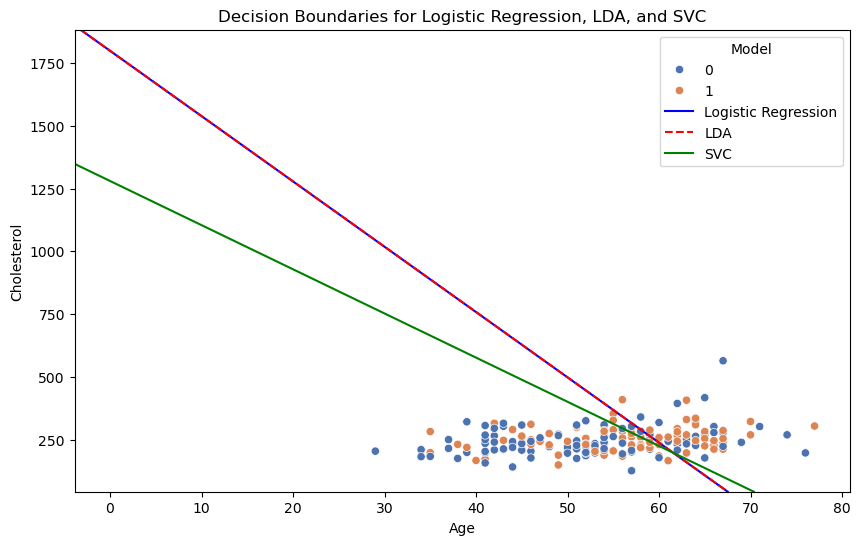

In [131]:
#scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='age', y='chol', hue='diagnosis', palette='deep')

#logistic boundary
plt.axline(xy1=(0, -intercept_log / coef_chol_log), slope=-coef_age_log / coef_chol_log, color='blue', label='Logistic Regression')
#lda boundary
plt.axline(xy1=(0, -int_lda / coef_lda[1]), slope=-coef_lda[0] / coef_lda[1], color='red', linestyle='--', label='LDA')
#svc boundary
plt.axline(xy1=(0, -int_svc / coef_svc[1]), slope=-coef_svc[0] / coef_svc[1], color='green', label='SVC')

#legend and labels
plt.legend(title='Model')
plt.xlabel('Age')
plt.ylabel('Cholesterol')
plt.title('Decision Boundaries for Logistic Regression, LDA, and SVC')
plt.show()

Upon inspection of the Logistic and LDA regression models, the coefficients are extremely similar in magnitude, which is why the lines are basically on top of one another.